### **Based off of RRL_opt-fixed.ipynb**
Trains off of real data. Also uses Downside Deviation as opposed to Sharpe Ratio.

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import math
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
import pandas as pd
import pickle
df = pd.read_csv('tickers.csv')
tickers = list(df.loc[:, "Symbol"])

try:
    with open("hists.dat", "rb") as f:
        hists = pickle.load(f) 
except:
    hists = []
    for x in range(len(tickers)):
        print("LOADING TICKER " + str(x) + "/" + str(len(tickers)), end="\r")
        hist = yf.Ticker(tickers[x]).history(interval="1h", period="2y")
        if not hist.empty and np.sum(np.isnan(hist.loc[:, "Open"].to_numpy())) == 0:
            hists.append(hist.loc[:, "Close"].to_numpy())
with open("hists.dat", "wb") as f:
    pickle.dump(hists, f)

# price_hists = []
# for ticker in tickers:
#     price_hists.append(yf.Ticker(ticker).history(interval='1h', start='2022-03-01', end='2024-02-01')['Close'].to_numpy())

In [3]:
def normalize_price_series(price_series):
    # initial_prices = price_series[:, 0]
    # range = np.max(price_series, axis=1) - np.min(price_series, axis=1)
    # scaled_prices = (price_series - np.repeat(initial_prices[:, np.newaxis], price_series.shape[1], axis=1)) / np.repeat(range[:, np.newaxis], price_series.shape[1], axis=1)
    
    # return np.exp(scaled_prices)

    return np.log(price_series) / np.log(2)

LENGTH = 3502

zt_list = [normalize_price_series(hist[np.newaxis, :]) for hist in hists]
to_pop = []
for i in range(len(zt_list)):
    if zt_list[i].shape[1] != LENGTH:
        to_pop.append(i)
to_pop.reverse()

print("popping: ", to_pop)

for i in to_pop:
    zt_list.pop(i)

a = 0
for i in range(len(zt_list)):
    a += zt_list[i].shape[1]
    # print(zt_list[i].shape[1])
print(a, "data points")
print(len(zt_list), "tickers")

popping:  [482, 478, 465, 435, 430, 421, 409, 405, 399, 379, 332, 323, 322, 318, 316, 289, 285, 271, 270, 258, 257, 228, 212, 211, 199, 184, 181, 172, 167, 121, 113, 112, 99, 96, 68, 66, 57, 43, 27]
1614422 data points
461 tickers


In [4]:
# Following 3 functions take whole arrays, of shape (instances, size)

def gen_price_series(size=10000, k=3, a=0.9, instances=1):
    p_series = np.ndarray((instances, size,), dtype=np.float32)
    b_series = np.ndarray((instances, size,), dtype=np.float32)
    p_series[:, 0] = 0
    b_series[:, 0] = 0

    for i in range(1, size):
        p_series[:, i] =  p_series[:, i-1] + b_series[:, i-1] + k * np.random.normal(size=instances)
        b_series[:, i] = a * b_series[:, i-1] + np.random.normal(size=instances)

    # shape: (instances)
    R = np.max(p_series, axis=1) - np.min(p_series, axis=1)
    z_series = np.exp(p_series / np.repeat(R[:, np.newaxis], size, axis=1))

    return z_series

def calc_price_returns(zt):
    # returns the set rt, with the first element (0) being NaN
    rt = np.ndarray(zt.shape, dtype=np.float32)
    rt[:, 0] = np.nan
    rt[:, 1:] = zt[:, 1:] - zt[:, :-1]
    return rt

def EMA(data, a):
    ema = np.zeros(data.shape)

    ema[:, 0] = data[:, 0]

    for t in range(1, data.shape[1]):
        ema[:, t] = a * data[:, t] + (1 - a) * ema[:, t-1]

    return ema


# Following 2 functions take slices of the arrays, of shape (instances,)

def calc_return(mu, rt, Ft_curr, Ft_prev, rft=tf.constant(0.0), delta=tf.constant(0.0)):
    '''Calculates the returns (Rt) on-line.'''

    return mu * (rft + Ft_prev * (rt - rft) - delta * tf.math.abs(Ft_curr - Ft_prev))

def calc_Dt(n, Rt, DDt_prev, At_prev):
    At_curr = At_prev + n * (Rt - At_prev)

    Rt_min = tf.where(Rt < 0, Rt, 0.0) # Rt = min(Rt, 0)
    DDt_curr = tf.math.square(DDt_prev) + n * (tf.math.square(Rt_min) - tf.math.square(DDt_prev))
    DDt_curr = tf.math.sqrt(DDt_curr)

    mask = tf.where(Rt > 0, 1.0, 0.0)
    Dt1 = (Rt - At_prev / 2) / DDt_prev
    Dt2 = (tf.math.square(DDt_prev) * (Rt - At_prev / 2) - (At_prev * tf.math.square(Rt) / 2)) / tf.math.pow(DDt_prev, 3)
    dDt1 = 1 / DDt_prev
    dDt2 = 1 / DDt_prev - At_prev * Rt / tf.math.pow(DDt_prev, 3)

    Dt = mask * Dt1 + (1.0 - mask) * Dt2
    dDt_dRt = mask * dDt1 + (1.0 - mask) * dDt2

    return Dt, dDt_dRt, DDt_curr, At_curr
    


from math import prod
# Repeat grades of shape (instances,) to shape (instances,) + grad.shape
def reshape_grad(grad, shape):
    # takes a tf.Tensor grad of shape (instances,) and the target shape (variables)
    instances = grad.shape[0]
    total_elements = prod(shape)
    grad = tf.repeat(grad, int(total_elements / instances))
    grad = tf.reshape(grad, shape)
    
    return grad

In [5]:
# Simulate trading using the outputs of the model
# Takes SLICES of the arrays, of shape (instances,)

def test_performance(zt, Ft):
    # zt: (instances, size)
    # Ft: (instances, size)

    instances = zt.shape[0]
    size = zt.shape[1]
    Ft = np.sign(Ft)

    initial_values = zt[:, 0]

    values = np.ones((instances, size))
    owned = np.zeros((instances,))
    money = np.zeros((instances,)) + initial_values
    values[:, :INPUT_SIZE] = money

    values_ideal = np.ones((instances, size))
    owned_ideal = np.zeros((instances,))
    money_ideal = np.zeros((instances,)) + initial_values
    values_ideal[:, :INPUT_SIZE] = money_ideal

    for t in range(INPUT_SIZE, size - 1):

        # Model Ft

        # buy if Ft 1, owned 0 --> owned 1
        # sell if Ft -1, owned 1 --> owned 0

        # hold if Ft 0, owned 0 or 1
        # hold if Ft 1, owned 1
        # hold if Ft -1, owned 0

        # model
        buy = np.clip(Ft[:, t] * (1 - owned), 0, 1) # 1 if BUY, 0 if not
        sell = np.clip(-Ft[:, t] * owned, 0, 1) # 1 if SELL, 0 if not
        decision = buy - sell # 1 if BUY, -1 if SELL, 0 if HOLD
        owned = np.clip(owned + decision, 0, 1)
        money -= decision * zt[:, t]
        values[:, t] = money + owned * zt[:, t]

        # ideal
        deltas_ideal = np.sign(zt[:, t + 1] - zt[:, t])
        buy_ideal = np.clip(deltas_ideal * (1 - owned_ideal), 0, 1)
        sell_ideal = np.clip(-deltas_ideal * owned_ideal, 0, 1)
        decision_ideal = buy_ideal - sell_ideal
        owned_ideal = np.clip(owned_ideal + decision_ideal, 0, 1)
        money_ideal -= decision_ideal * zt[:, t]
        values_ideal[:, t] = money_ideal + owned_ideal * zt[:, t]
    
    values[:, -1] = np.nan
    values_ideal[:, -1] = np.nan

    return (values[-1] / zt[-1], values_ideal[-1] / zt[-1]), (values, values_ideal)


In [6]:
@tf.function
def calc_grads(zt, rt, DDt, At, N, MU, F_model, F_prev, rft=tf.constant(0.0), transaction_cost=tf.constant(0.0), random=tf.constant(1.0)):
    '''
    zt: zt[:, t - INPUT_SIZE + 1:t + 1]
    rt: rt[:, t]
    DDt: DDt[:, t - 1]
    At: At[:, t-1]
    '''

    # print("TRACING calc_grads()")

    INSTANCES = zt.shape[0]

    with tf.GradientTape(persistent=True) as tape:
        F_curr = tf.reshape(F_model(zt), (INSTANCES,))

        Rt = calc_return(MU, rt, F_curr, F_prev, rft, transaction_cost)
        Dt, dDt_dRt, DDt_new, At_new = calc_Dt(N, Rt, DDt, At)

    # calculate derivatives.
    # dDt_dRt = tape.gradient(Dt, Rt)
    a = tape.gradient(Dt, Rt)
    dRt_dFcurr = tape.gradient(Rt, F_curr) # shape: (instances,)
    dRt_dFprev = tape.gradient(Rt, F_prev) # shape: (instances,)
    dF_dTheta = tape.jacobian(F_curr, F_model.trainable_variables) # shape: (instances, MODEL VAR SHAPE)

    return Rt, F_curr, DDt_new, At_new, dDt_dRt, dRt_dFcurr, dRt_dFprev, dF_dTheta

In [7]:
# Define da model

from keras import layers

INPUT_SIZE = 30
TANH_CONSTANT = 0.01

input = layers.Input(shape=(INPUT_SIZE,))
x = layers.Dense(30, activation='elu')(input)
x = layers.Dropout(0.5)(x)
x = layers.Dense(20, activation='elu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(1, activation='linear')(x)
x = layers.Add()([tf.math.tanh(x), x * tf.constant(TANH_CONSTANT, dtype=tf.float32)]) # This bit is the activation function: tanh(x) + x * TANH_CONSTANT
F_model = keras.Model(inputs=input, outputs=x)
F_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 30)           930         ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 30)           0           ['dense[0][0]']                  
                                                                                                  
 dense_1 (Dense)                (None, 20)           620         ['dropout[0][0]']                
                                                                                              

# 0: MMM
Mean gradient:  3.0798668635465142e-06
Mean clipped gradient:  2.5330172332760737e-06
# of trades:  0.0
mean SR:  0.1477877871798613
mean DDRT:  0.6154556042569416


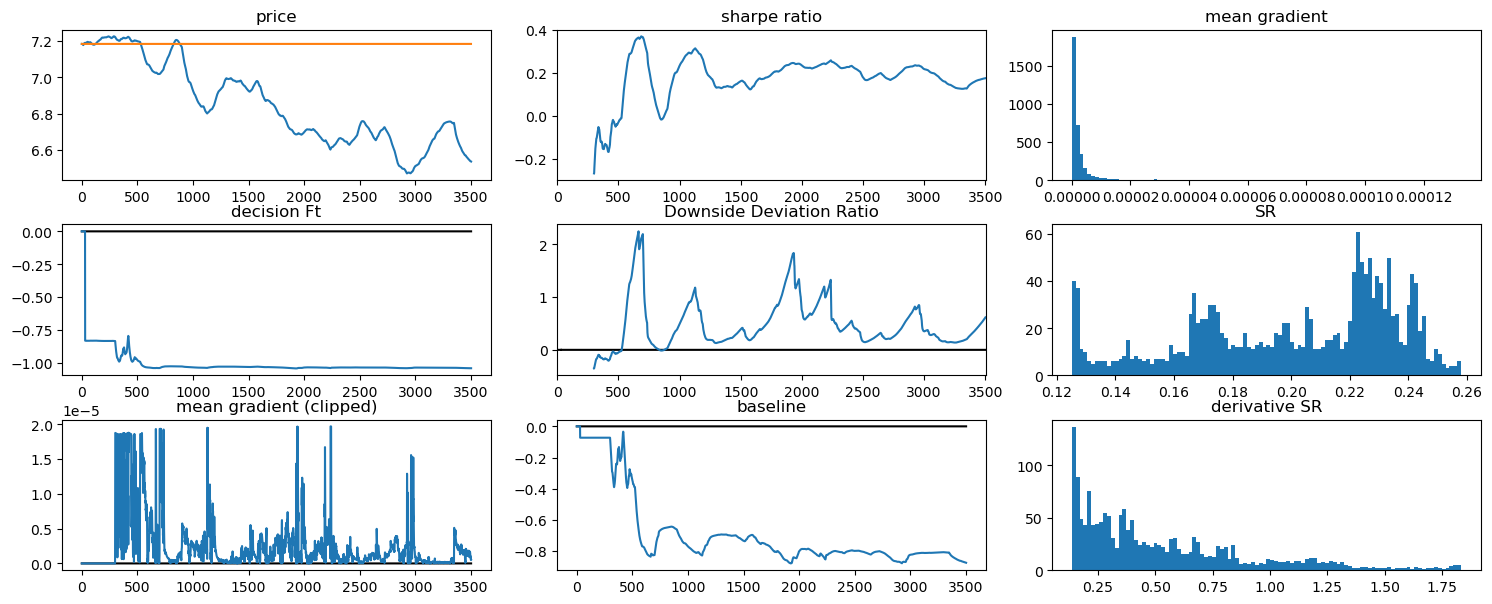

# 1: AOS
Mean gradient:  1.1337812558986292e-06
Mean clipped gradient:  1.111860302947828e-06
# of trades:  0.0
mean SR:  0.15583067975815074
mean DDRT:  -0.17362694744082147


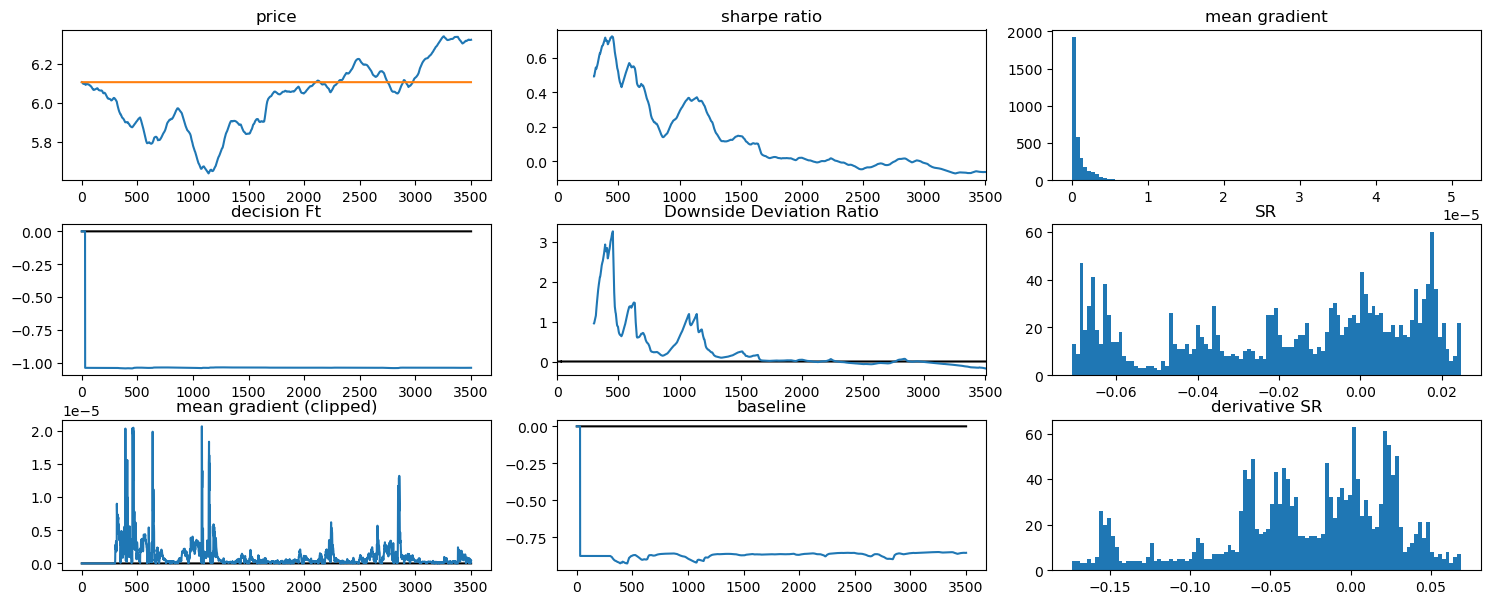

# 2: ABT
Mean gradient:  1.337312431250119e-06
Mean clipped gradient:  1.256863711609838e-06
# of trades:  0.0
mean SR:  0.12162452588100957
mean DDRT:  0.02465446122736253


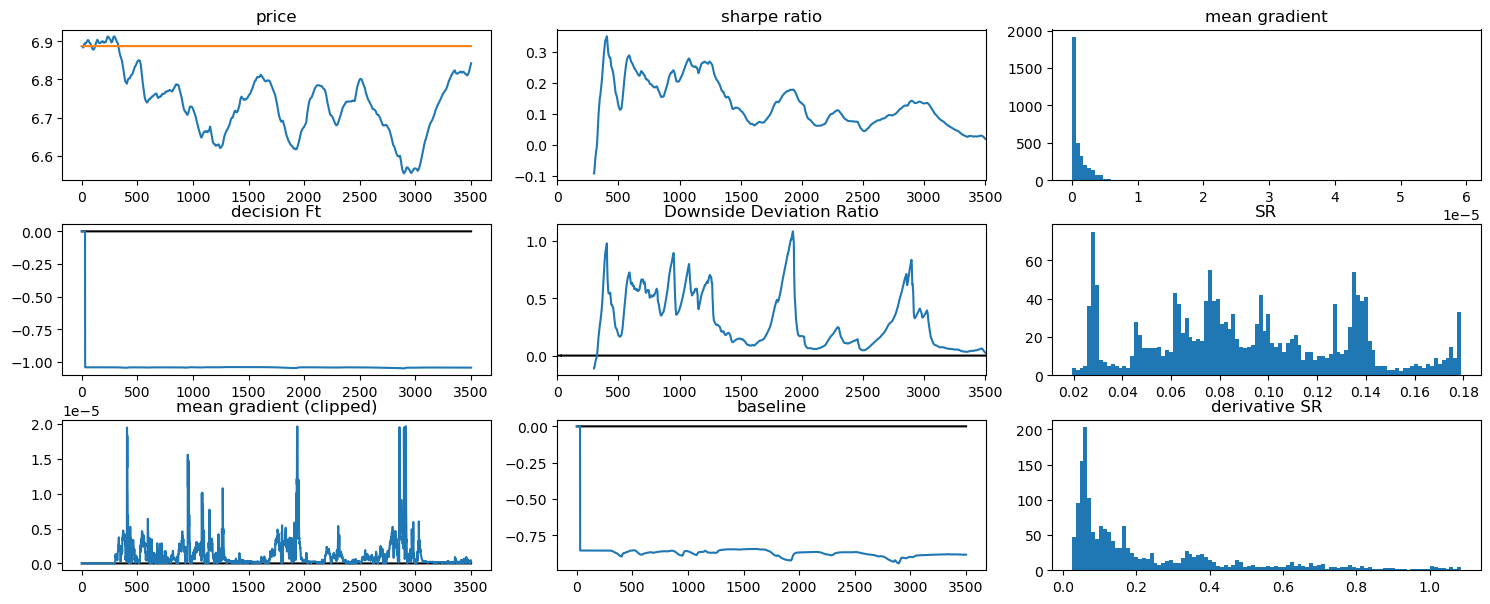

KeyboardInterrupt: 

In [8]:
import warnings, sys
warnings.filterwarnings("ignore")

# GENERATION VARS
import time

'''
A N0TE ON THE PARAMETERS:

These parameters are appropriate for one data point per DAY.

The artificial price series start at a value of 1.0, and normally scales between 0.5-2.0. 
A conversion of 1.0 to $100 is used, so the principal is $100.
A transaction cost of 0.1 ($10) is therefore imposed (based on RBC standard order fees).
A risk-free return of 4.00% for a $5000 3-year gov. bond is used (converted to $100 principal), 
    which converts to 0.04 / 252 (1.59E-4, $0.0159 a day).
'''

# HYPERPARAMETERS
if True:
    LEARNING_RATE = 0.0001
    MAX_GRAD = 10. * LEARNING_RATE

    MU = tf.constant(3.0)
    N = tf.constant(0.01)
    K = 3
    A = 0.9
    # RISKFREE_RETURN = tf.constant(1.59e-4)
    RISKFREE_RETURN = tf.constant(0.0)
    # TRANS_COST = tf.constant(0.1)
    TRANS_COST = tf.constant(0.0)
    TRADING_DELAY = 300

    REAL_INSTANCES = 1
    SIM_INSTANCES = 0
    INSTANCES = REAL_INSTANCES + SIM_INSTANCES

# trim off the last bit so that the data is divisible by the number of instances.
max_len = len(zt_list) % REAL_INSTANCES
if max_len != 0:
    zt_list = zt_list[0:-max_len]
BASELINE_ZT = gen_price_series(size=LENGTH, k=K, a=A, instances=INSTANCES)

for ep in range(int(len(zt_list) / REAL_INSTANCES)):

    # DEFINE A BUNCH OF STUFF
    if True:
        # generate price series
        zt_real = np.array(zt_list[ep * REAL_INSTANCES: (ep + 1) * REAL_INSTANCES]).reshape(REAL_INSTANCES, -1)
        ''' AAAAAAAA '''
        zt_real = EMA(zt_real, 0.025)

        SERIES_LENGTH = zt_real.shape[1]
        # SERIES_LENGTH = 3502
        zt_sim = gen_price_series(size=SERIES_LENGTH, k=K, a=A, instances=SIM_INSTANCES)
        # zt_sim = gen_price_series(size=SERIES_LENGTH, k=K, a=A, instances=INSTANCES)
        # zt = zt_sim

        zt = np.vstack((zt_real, zt_sim))
        rt = calc_price_returns(zt)
        Ft = np.zeros((INSTANCES, SERIES_LENGTH,), dtype=np.float32)

        # breaks if init at one; MUST INIT ZERO
        DDt = np.zeros((INSTANCES, SERIES_LENGTH), dtype=np.float32)
        At = np.zeros((INSTANCES, SERIES_LENGTH,), dtype=np.float32)
        dF_dTheta_prev = None

        Rt_series = np.zeros((INSTANCES, SERIES_LENGTH,))
        SR_series = np.zeros((INSTANCES, SERIES_LENGTH,))
        DSR_series = np.zeros((INSTANCES, SERIES_LENGTH,))
        DDRT_series = np.zeros((INSTANCES, SERIES_LENGTH,))
        dD_series = np.ones((INSTANCES, SERIES_LENGTH,))
        autodiff_series = np.ones((INSTANCES, SERIES_LENGTH,))
        bench_series = np.zeros((INSTANCES, SERIES_LENGTH,))
        grad_series = np.zeros((SERIES_LENGTH,))
        gradC_series = np.zeros((SERIES_LENGTH,))
        trade_count = np.zeros((INSTANCES,))
        baseline_series = np.zeros((INSTANCES, SERIES_LENGTH,))

        ddt_start = 0

        # grad series
        w1_series = np.zeros((INSTANCES, SERIES_LENGTH,))
        b_series = np.zeros((INSTANCES, SERIES_LENGTH,))
        w1g_series = np.zeros((INSTANCES, SERIES_LENGTH,))
        bg_series = np.zeros((INSTANCES, SERIES_LENGTH,))

    for t in range(INPUT_SIZE, SERIES_LENGTH):

        if t >= INPUT_SIZE + 2:
            aaa = 1
        Rt, Ft[:, t], DDt[:, t], At[:, t], dDt_dRt, dRt_dFcurr, dRt_dFprev, dF_dTheta = calc_grads(zt[:, t - INPUT_SIZE + 1:t + 1], rt[:, t], DDt[:, t-1], At[:, t-1], N, MU, F_model, tf.Variable(Ft[:, t-1]), RISKFREE_RETURN, TRANS_COST)

        if DDt[0, t] == 0 and t >= INPUT_SIZE + 2:
            a = 1
            
        pos_changes = np.where(Ft[:, t] * Ft[:, t-1] < 0, 1, 0)
        trade_count += pos_changes


        '''DIAGNOSTICS. -----------------'''
        Rt_series[:, t] = Rt
        SR_series[:, t] = np.mean(Rt_series[:, INPUT_SIZE:t], axis=1) / np.std(Rt_series[:, INPUT_SIZE:t], axis=1)
        T = t - INPUT_SIZE
        DDRT_series[:, t] = np.mean(Rt_series[:, INPUT_SIZE:t], axis=1) / DDt[:, t]
        if DDRT_series[:, t] == np.inf and t >= INPUT_SIZE + 2:
            a = np.mean(Rt_series[:, INPUT_SIZE:t], axis=1)
            b = DDt[:, t]
            c = 1
            
        # DSR_series[:, t] = (Bt[:, t-1] * (Rt - At[:, t-1]) - (1/2) * (At[:, t-1] * (Rt ** 2 - Bt[:, t-1]))) / ((Bt[:, t-1] - At[:, t-1] ** 2) ** 1.5)
        dD_series[:, t] = dDt_dRt
        bench_series[:, t] = F_model(zt[:, -INPUT_SIZE:]).numpy().reshape(INSTANCES)
        '''---------------------------------'''
        
        if np.where(SR_series[:, t] > 1.5, True, False).any():
            a = np.mean(Rt_series[:, INPUT_SIZE:t], axis=1)
            b = np.std(Rt_series[:, INPUT_SIZE:t], axis=1)
            pass

        '''THIS BIT APPLIES THE GRADIENTS. --------------'''
        # if (t != INPUT_SIZE) and t >= TRADING_DELAY:
        if (t != INPUT_SIZE) and t >= TRADING_DELAY and np.all(DDt[:, t-1] > 0):
            a = DDt[:, t]
            ddt_start = t
            if dDt_dRt == np.nan or DDt[0, t] == 0:
                a = 1

            # multiply derivatives together.
            gradient_update = []

            grad_mean = np.ndarray((len(dF_dTheta),), dtype=np.float32)

            for i in range(len(dF_dTheta)):
                total_elements = prod(dF_dTheta[i].shape)

                # expand the "scalar" derivatives to the shape of the model variables. (jacobians)
                dDt_dRt_exp = reshape_grad(dDt_dRt, dF_dTheta[i].shape)
                dRt_dFcurr_exp = reshape_grad(dRt_dFcurr, dF_dTheta[i].shape)
                dRt_dFprev_exp = reshape_grad(dRt_dFprev, dF_dTheta[i].shape)

                grad = dDt_dRt_exp * (dRt_dFcurr_exp * dF_dTheta[i] + dRt_dFprev_exp * dF_dTheta_prev[i])
                grad = tf.reduce_sum(grad, axis=0)
                grad *= LEARNING_RATE / INSTANCES # divide by instances since the gradients are summed over all instances.

                gradient_update.append(grad)
                grad_mean[i] = tf.reduce_mean(tf.math.abs(grad))
                
            grad_series[t] = np.mean(grad_mean)

            before = F_model(zt[0, t - INPUT_SIZE:t].reshape(1, -1))

            # print(gradient_update)
            gradient_update = tf.clip_by_global_norm(gradient_update, MAX_GRAD)[0]
            # print(gradient_update)

            # actually add the grads
            vars = F_model.trainable_variables
            grad_mean = np.ndarray((len(dF_dTheta),), dtype=np.float32)
            for i in range(len(vars)):
                # grad = np.clip(gradient_update[i], -MAX_GRAD, MAX_GRAD)
                grad = gradient_update[i]
                grad_mean[i] = tf.reduce_mean(tf.math.abs(grad))
                vars[i].assign_add(grad)
            gradC_series[t] = np.mean(grad_mean)

            after = F_model(zt[0, t - INPUT_SIZE:t].reshape(1, -1))

            
            # w1_series[:, t] = F_model.trainable_variables[0].numpy()
            # b_series[:, t] = F_model.trainable_variables[1].numpy()
            # w1g_series[:, t] = gradient_update[0].numpy()
            # bg_series[:, t] = gradient_update[1].numpy()
            '''--------------------------------------------'''
            # if Rt <= 0 and At[0, t-1] < 0:
            #     print("t:", t, "=============================================================")
            #     print("return: ", Rt)
            #     print("dDt_dRt: ", dDt_dRt)
            #     print("dRt_dFcurr: ", dRt_dFcurr)
            #     print("dRt_dFprev: ", dRt_dFprev)
            #     print("dF_dTheta: ", dF_dTheta[-1], "\n")
            #     print("At prev: ", At[0, t-1])
            #     print("Ft curr: ", Ft[0, t])
            #     print("Ft prev: ", Ft[0, t-1])
            #     print("rt: ", rt[0, t])
            #     print("GRAD for b: ", gradient_update[-1], "\n")
            #     print("input before: ", tf.math.atanh(before))
            #     print("input after: ", tf.math.atanh(after))
            #     print("before: ", before)
            #     print("after: ", after)
            #     print("\n")

            # if True:
            #     a = dF_dTheta[-1].numpy()
            #     b = At[0, t-1]
            #     c = Ft[0, t]
            #     d = Ft[0, t-1]
            #     e = rt[0, t]
            #     f = gradient_update[-1].numpy()
            #     g = tf.math.atanh(before).numpy()
            #     h = tf.math.atanh(after).numpy()
            #     i = before.numpy()
            #     j = after.numpy()
                
            #     k = DDt[0, t-1]
            #     l = dDt_dRt.numpy()

            # if Rt > 0:
            #     if not gradient_update[-1] * rt[0, t] >= 0:
            #         a = 1 # if the grad and rt are different signs, this is wrong.
            #         print("SUM TING WONG")
            #         _, _, _, _ = calc_Dt(N, Rt, DDt, At)
            # if Rt <= 0:
            #     if At[0, t-1] <= tf.math.square(DDt[0, t-1] / Rt):
            #         # dDt/dRt is positive
            #         if not gradient_update[-1] * rt[0, t] >= 0:
            #             a = 1 # if the grad and rt are different signs, this is wrong.
            #             print("SUM TING WONG")
            #             _, _, _, _ = calc_Dt(N, Rt, DDt[:, t-1], At[:, t-1])
            #     else:
            #         # dDt/dRt is negative
            #         if not gradient_update[-1] * rt[0, t] <= 0:
            #             a = 1
            #             print("SUM TING WONG")
            #             _, _, _, _ = calc_Dt(N, Rt, DDt, At)
            


        if t >= TRADING_DELAY - 1:
            # need to continously update so that the first training step has a t-1 value.
            dF_dTheta_prev = dF_dTheta


        baseline_series[:, t] = F_model(BASELINE_ZT[:, -INPUT_SIZE:]).numpy()

    '''PLOT DIAGNOSTICS. -----------------'''
    if ep % 1 == 0: 
        print("# {0}: {1}".format(ep * REAL_INSTANCES, tickers[ep * REAL_INSTANCES]))
        print("Mean gradient: ", np.mean(grad_series))
        print("Mean clipped gradient: ", np.mean(gradC_series))
        # test performance
        deltas, val_series = test_performance(zt, Ft)

        for i in range(1):
            print("# of trades: ", trade_count[i])
            print("mean SR: ", np.mean(SR_series[i, INPUT_SIZE + 2:]))
            print("mean DDRT: ", np.mean(DDRT_series[i, ddt_start:]))

            fig, ax = plt.subplots(3, 3, figsize=(15, 6))
            fig.tight_layout()

            ax[0, 0].plot(zt[i])
            ax[0, 0].plot(val_series[0][i])
            ax[0, 0].set_title("price")

            ax[1, 0].plot(Ft[i] * 0, color='k')
            ax[1, 0].plot(Ft[i])
            # ax[1, 0].set_ylim([-1, 1])
            ax[1, 0].set_title("decision Ft")

            # ax[2, 0].plot(bench_series[i] * 0, color='k')
            # ax[2, 0].plot(bench_series[i])
            # ax[2, 0].set_ylim([-1, 1])
            # ax[2, 0].set_title("benchmark Ft")
            ax[2, 0].plot(grad_series * 0, color='k')
            ax[2, 0].plot(gradC_series)
            # ax[2, 0].set_ylim([-1, 1])
            ax[2, 0].set_title("mean gradient (clipped)")

        
            SR_cut = SR_series.copy()
            SR_cut[:, :TRADING_DELAY] = np.nan
            ax[0, 1].plot(SR_cut[i])
            ax[0, 1].set_xlim([0, SERIES_LENGTH])
            ax[0, 1].set_title("sharpe ratio")

            DDRT_cut = DDRT_series.copy()
            DDRT_cut[:, :TRADING_DELAY] = np.nan
            ax[1, 1].plot(DDRT_series[i] * 0, color='k')
            ax[1, 1].plot(DDRT_cut[i])
            ax[1, 1].set_xlim([0, SERIES_LENGTH])
            ax[1, 1].set_title("Downside Deviation Ratio")

            ax[2, 1].plot(baseline_series[i] * 0, color='k')
            ax[2, 1].plot(baseline_series[i])
            # ax[2, 1].set_ylim([-1, 1])
            ax[2, 1].set_title("baseline")

            ax[0, 2].hist(grad_series, bins=100)
            ax[0, 2].set_title("mean gradient")
            ax[1, 2].hist(SR_cut[i, int(SERIES_LENGTH / 2):], bins=100)
            ax[1, 2].set_title("SR")
            ax[2, 2].hist(DDRT_cut[i, int(SERIES_LENGTH / 2):], bins=100)
            ax[2, 2].set_title("derivative SR")
            
            # ax[3, 0].plot(w1_series[i])
            # ax[3, 0].set_title("w1 variable")
            # ax[3, 1].plot(b_series[i])
            # ax[3, 1].set_title("bias variable")
            # ax[4, 0].plot(w1g_series[i])
            # ax[4, 0].set_title("w1 grad")
            # ax[4, 1].plot(bg_series[i])
            # ax[4, 1].set_title("bias grad")

            plt.show()

        print("==========================================================================")

    '''-----------------------------------'''



In [ ]:
Rt = tf.Variable((1.0, -1.0, 1.0))
DDt_prev = tf.Variable((1.0, 1.0, 1.0))
At_prev = tf.Variable(np.random.rand(3), dtype=tf.float32)

with tf.GradientTape(persistent=True) as tape:
    mask = tf.where(Rt > 0, 1.0, 0.0)
    Dt1 = (Rt - At_prev / 2) / DDt_prev
    Dt2 = (tf.math.square(DDt_prev) * (Rt - At_prev / 2) - (At_prev * tf.math.square(Rt) / 2)) / tf.math.pow(DDt_prev, 3)
    dDt1 = 1 / DDt_prev
    dDt2 = 1 / DDt_prev - Rt * At_prev / tf.math.pow(DDt_prev, 3)

    Dt = mask * Dt1 + (1 - mask) * Dt2
    dDt_dRt = mask * dDt1 + (1 - mask) * dDt2

a = tape.gradient(Dt, Rt)
print(a)

print(dDt_dRt)

In [ ]:
keras.models.save_model(F_model, "model.h5")